In [1]:
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import cv2
import os
import pandas as pd

In [2]:
data_dir = './data/udacity_data'
cvs_file = os.path.join(data_dir, 'driving_log.csv')
dataset=pd.read_csv(cvs_file)

print('Number of images per camera in the log file : {}'.format(dataset.shape[0]))
dataset.head(5)

Number of images per camera in the log file : 8036


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
dataset['steering'].describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

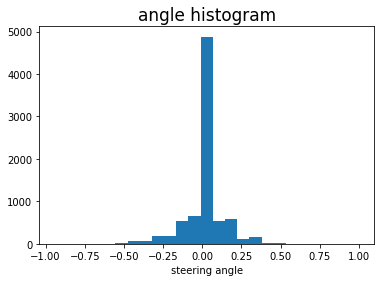

In [4]:
plt.hist(dataset['steering'],bins=25)
plt.title('angle histogram', fontsize=17)
plt.xlabel('steering angle')
plt.show()

In [5]:
def read_image(dataset, data_dir, img_index, img_position = 'center'):
        
    imgs = dataset.iloc[img_index]
    center_steering = imgs['steering']
    img_path = os.path.join(data_dir, imgs[img_position].strip())
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, center_steering 

center steering: 0.0


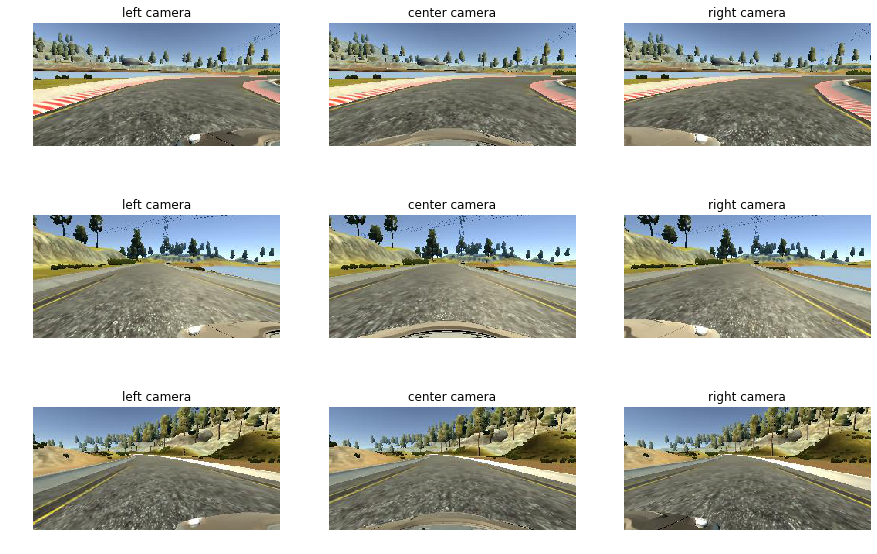

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(15,10))

for ax in axes:
    img_index = random.randrange(dataset.shape[0]) 
    for a, position in zip(ax, ['left', 'center', 'right']):
        img, center_steering = read_image(dataset, data_dir, img_index, position)
        a.set_title(position+' camera')
        a.imshow(img)
        a.axis('off')
print("center steering:",center_steering )

In [7]:
def change_brightness(image):
    br_img = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .2 + np.random.uniform(0.2, 0.6)
    br_img[:,:,2] = br_img[:,:,2] * random_bright
    result = cv2.cvtColor(br_img,cv2.COLOR_HSV2RGB)
    return result

def resize_image(image, target_size = (64,64)):
     return cv2.resize(image, target_size) 
    
def crop_image(image):
    return image[55:135,:,:]

def flip_image(image):
    return cv2.flip(image, 1)

def preprocess_image(image):
    img = crop_image(image)
    img = resize_image(img, target_size = (64,64))
    img = img.astype(np.float32)
    img = (img/127.5) - 1
    return img

center steering: 0.061759900000000006


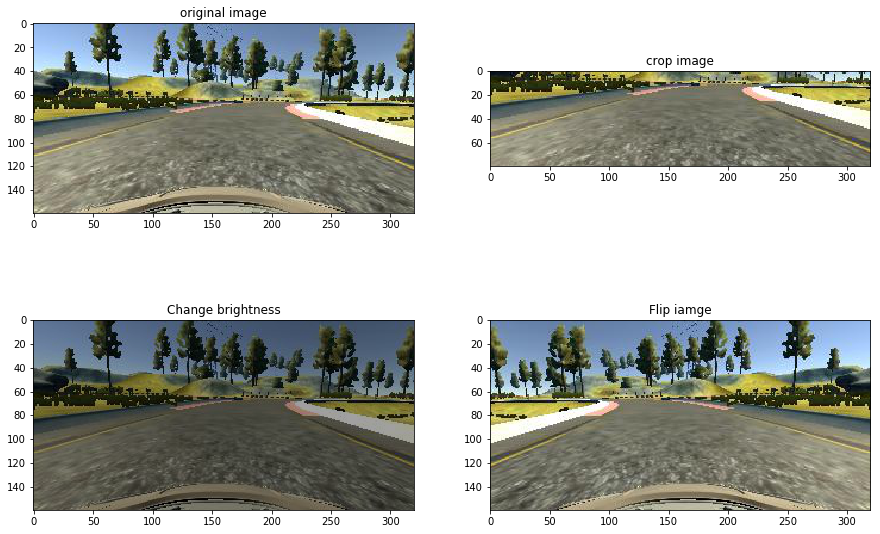

In [8]:
image, center_steering = read_image(dataset, data_dir, 2500, 'center')
fig, axes = plt.subplots(2, 2, figsize=(15,10))

axes[0][0].imshow(image)
axes[0][0].set_title("original image")

axes[0][1].imshow(crop_image(image))
axes[0][1].set_title("crop image")

axes[1][0].imshow(change_brightness(image))
axes[1][0].set_title("Change brightness")

axes[1][1].imshow(flip_image(image))
axes[1][1].set_title("Flip iamge")

print("center steering:",center_steering )

In [9]:
def generate_augmented_image(dataset, img_index):
    # randomly choose camera position
    img_position = np.random.choice(['center', 'left', 'right']);
    
    #read image 
    image, center_steering = read_image(dataset, data_dir, img_index, img_position)
    
    # adjust the steering angle based on cameras position 
    if img_position == 'left':
        steering = center_steering + 0.25
    elif img_position == 'right':
        steering = center_steering - 0.25
    elif img_position == 'center':
        steering = center_steering
    
    #randomly change image brightness 
    image = change_brightness(image)
    
    #randomly flip image 
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        image = flip_image(image)
        steering = -1*steering
    
    #fianlly, crop, resize and normalize image 
    image = preprocess_image(image)
    return image, steering

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


center steering: 0.061759900000000006


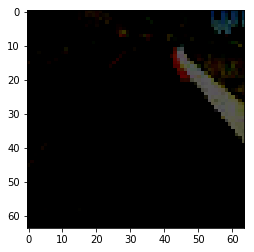

In [12]:
image, steering = generate_augmented_image(dataset ,2500)
plt.imshow(image)
print("center steering:", steering )

In [13]:
def batch_generator(dataset, batch_size =32):
    N = dataset.shape[0]
    num_batches = N // batch_size
    
    while True:
        for i in range(num_batches):
            start = i*batch_size
            end = start-1 + batch_size
            X_batch = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
            y_batch = np.zeros((batch_size,), dtype=np.float32)


            for batch_index, img_index in zip(range(32),range(start,end)):
                X_batch[batch_index], y_batch[batch_index] = generate_augmented_image(dataset, img_index)

            yield X_batch, y_batch

In [14]:
from keras.models import Sequential
from keras.layers import Convolution2D, Flatten, Dropout, Dense, Activation, MaxPooling2D

Using TensorFlow backend.


In [15]:
model = Sequential()
model.add(Convolution2D(24,5,5, input_shape=(64, 64, 3), subsample=(2,2), activation= "relu"))
model.add(Convolution2D(38,5,5, subsample=(2,2), activation= "relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation= "relu"))
model.add(Convolution2D(64,3,3, activation= "relu"))
model.add(Convolution2D(64,3,3, activation= "relu"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dense(1))
model.summary()

t:\Users\Tao Tao\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), input_shape=(64, 64, 3..., activation="relu")`
  
t:\Users\Tao Tao\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(38, (5, 5), strides=(2, 2), activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
t:\Users\Tao Tao\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
  after removing the cwd from sys.path.
t:\Users\Tao Tao\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  """
t:\Users\Tao Tao\Anaconda3\envs\carnd-term1\lib\si

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 38)        22838     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 48)          45648     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
__________